# Pymaceuticals Inc.
---

### Analysis
* Your analysis here ...

In [88]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import random

# set seed
random.seed(69)

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
combined_df = pd.merge(study_results, mouse_metadata, on = "Mouse ID",
                      how="left")

# Display the data table for preview
combined_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


In [2]:
# Checking the number of mice.
len(combined_df["Mouse ID"].unique())

249

In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duped = combined_df[combined_df.duplicated()]
duped[["Mouse ID", "Timepoint"]]

,Mouse ID,Timepoint
137,g989,0


In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
all_g989 = combined_df.loc[combined_df["Mouse ID"] == "g989"]
all_g989

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
all_g989_index = all_g989.index
clean_df = combined_df.drop(index = all_g989_index)
clean_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


In [6]:
# Checking the number of mice in the clean DataFrame.
len(clean_df["Mouse ID"].unique())

248

## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.

# Column definition
tumor_vol_col = ["Tumor Volume (mm3)"]

# Groupby definition
drug_grouped_df = clean_df.groupby(clean_df["Drug Regimen"])

# Keeping stuff DRY
tumor_vol = drug_grouped_df[tumor_vol_col]

# Stats definitions
mean_tumor_vol = tumor_vol.mean()
med_tumor_vol = tumor_vol.median()
var_tumor_vol = tumor_vol.var()
std_tumor_vol = tumor_vol.std()
sem_tumor_vol = tumor_vol.sem()

# drug_tumor summary df
drug_tumor_df = pd.DataFrame({
    "Mean Tumor Volume": mean_tumor_vol["Tumor Volume (mm3)"],
    "Median Tumor Volume": med_tumor_vol["Tumor Volume (mm3)"],
    "Tumor Volume Variance": var_tumor_vol["Tumor Volume (mm3)"],
    "Tumor Volume Std. Dev.": std_tumor_vol["Tumor Volume (mm3)"],
    "Tumor Volume Std. Err.": sem_tumor_vol["Tumor Volume (mm3)"]
})

drug_tumor_df

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
drug_agg_df = drug_grouped_df.agg(['mean', 'median', 'var', 'std', 'sem'])
drug_tumor_agg_df = drug_agg_df["Tumor Volume (mm3)"]
drug_tumor_agg_df

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

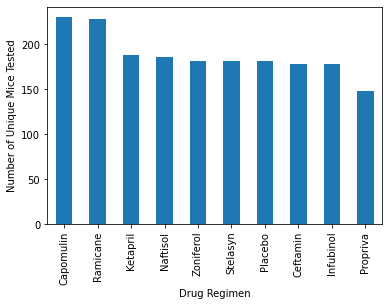

In [9]:
# Generate a bar plot showing the total number of unique mice tested on each drug regimen using pandas.
# drug_grouped_df["Mouse ID"].value_counts()
drug_trial_count = clean_df["Drug Regimen"].value_counts()

drug_trial_count.plot(kind = "bar")

plt.ylabel("Number of Unique Mice Tested")
plt.xlabel("Drug Regimen")

plt.show()

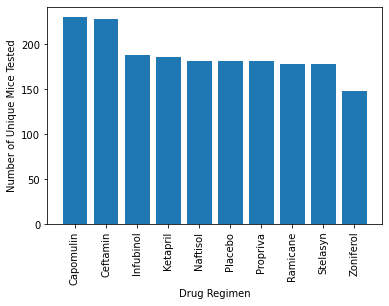

In [10]:
# Generate a bar plot showing the total number of unqiue mice tested on each drug regimen using using pyplot.
drug_trial_count = clean_df["Drug Regimen"].value_counts()
x_axis = np.arange(len(drug_grouped_df))

plt.bar(x_axis, drug_trial_count)

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, drug_tumor_agg_df.index, rotation = 'vertical')

plt.ylabel("Number of Unique Mice Tested")
plt.xlabel("Drug Regimen")

plt.show()

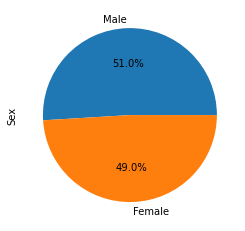

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
sex_count = clean_df["Sex"].value_counts()

sex_count.plot(kind = "pie", autopct = '%1.1f%%')

plt.ylabel("Sex")

plt.show()

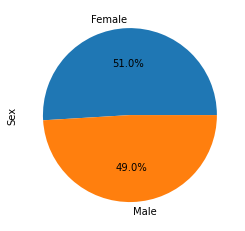

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
sex_count = clean_df["Sex"].value_counts()

plt.pie(sex_count, labels = clean_df["Sex"].unique(), autopct = "%1.1f%%")

plt.ylabel("Sex")

plt.show()

## Quartiles, Outliers and Boxplots

In [16]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
desc_timepoint_df = clean_df.sort_values(by=['Timepoint'], ascending=False)

grouped_ID_df = clean_df.groupby(by=["Mouse ID"])
max_time_df = grouped_ID_df["Timepoint"].max()

# max_time_df.head()
# Merge this group df with the original dataframe to get the tumor volume at the last timepoint

merge_df = pd.merge(clean_df, max_time_df, on = ("Mouse ID", "Timepoint"), how = "right")
merge_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,a203,45,67.973419,2,Infubinol,Female,20,23
1,a251,45,65.525743,1,Infubinol,Female,21,25
2,a262,45,70.717621,4,Placebo,Female,17,29
3,a275,45,62.999356,3,Ceftamin,Female,20,28
4,a366,30,63.440686,1,Stelasyn,Female,16,29


In [60]:
# Put treatments into a list for for loop (and later for plot labels)
treatment_list = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)
tumor_vol_list = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for drug in treatment_list:
    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    drug_max_time_df = merge_df.loc[merge_df["Drug Regimen"] == drug]
    drug_final_time_df = drug_max_time_df.loc[drug_max_time_df["Timepoint"]==drug_max_time_df["Timepoint"]]
    drug_final_tumor_vol_df = drug_max_time_df["Tumor Volume (mm3)"]

    # add subset 
    tumor_vol_list.append(drug_final_tumor_vol_df)
    
    # Determine outliers using upper and lower bounds   
    quartiles = drug_final_tumor_vol_df.quantile([.25, .5, .75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    upperbound = upperq + (1.5*iqr)
    lowerbound = lowerq - (1.5*iqr)
    outliers = (drug_final_tumor_vol_df.loc[(drug_final_time_df["Tumor Volume (mm3)"] >= upperbound) | 
                                           (drug_final_time_df["Tumor Volume (mm3)"] <= lowerbound)])
    # number of {drug} outliers
    print(f"{drug}'s potential outliers: {outliers}")
    print(f"")

Capomulin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)

Ramicane's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)

Infubinol's potential outliers: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64

Ceftamin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)



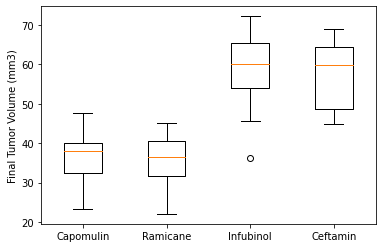

In [71]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
fig1, ax1 = plt.subplots()
ax1.boxplot(tumor_vol_list)

ax1.set_ylabel('Final Tumor Volume (mm3)')
ax1.set_xticklabels(treatment_list)

plt.show()
# Need to fill in the outlier circle with red

## Line and Scatter Plots

In [141]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
capomulin_only = clean_df.loc[clean_df["Drug Regimen"] =="Capomulin"]

# Randomly select a mouse from capomulin pool
random_mouse_id = capomulin_only["Mouse ID"].sample(1, random_state=1)
random_mouse_df = pd.DataFrame(random_mouse)
# random_mouse_df

# Defining relevent columns
random_mouse_id = capomulin_only.loc[capomulin_only["Mouse ID"] == random_mouse_df]
# mouse_time = random_mouse["Timepoint"]
# mouse_tum_vol = random_mouse["Tumor Volume (mm3)"]

# u364_treatment = plt.plot(mouse_time, mouse_tum_vol)
# plt.xlabel("Timepoint (days)")
# plt.ylabel("Tumor Volume (mm3)")

# plt.show()

ValueError: Cannot index with multidimensional key

In [94]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen


## Correlation and Regression

The correlation between mouse weight and the average tumor volume is 0.84


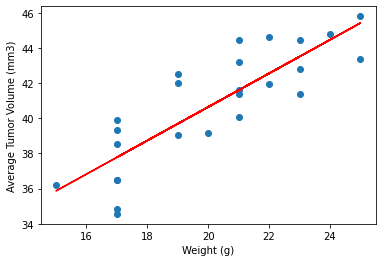

In [18]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
